# TCR Engineering Analysis

## Imports

In [1]:
import sys
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData
from Levenshtein import distance as l_dist

sys.path.append(str(Path.cwd().parent / 'tcr'))

import data_loader as dl
import mcmc
import model_utils
import plot_utils

## Set Device

In [2]:
device = 0

## Set Paths

In [21]:
parent_dir = Path.cwd().parent.parent
data_dir = parent_dir / 'data'
model_dir = parent_dir / 'models/lcmv_ab_finetune_cls_pooling_False_sharedencoder_0.2_dropout_25_epochs_3e-05_lr_linear_lrsched'
plot_dir = Path.cwd().parent.parent / 'plots'
plot_dir.mkdir(parents=True, exist_ok=True)

## Load LCMV Data

In [4]:
lcmv = dl.load_lcmv_table(
    fname=data_dir / 'lcmv_tetramer_tcr.txt',
    metadata_fname=data_dir / 'lcmv_all_metadata.txt',
    vdj_fname=data_dir / 'lcmv_tcr_vdj_unsplit.txt'
)
lcmv.head()

INFO:root:Loaded in table of 20351 entries
INFO:root:16768 entries remain after dropping na
INFO:root:15028 entries remain after dropping unsorted
INFO:root:20522 entries after expanding multiple entries
INFO:root:Class TetPos: 1819
INFO:root:Class TetNeg: 17477
INFO:root:Class TetMid: 1226


,tetramer,tcr_cdr3s_aa,tcr_cdr3s_nt,TRB,TRA,nCells,Prop,TRA_nt,TRB_nt,antigen.sequence,...,S.Score,G2M.Score,Phase,phenotype,v_a_gene,d_a_gene,j_a_gene,v_b_gene,d_b_gene,j_b_gene
0,TetPos,TRA:CAFEVVGQLTF;TRB:CASSFRDSSYEQYF,TRA:TGTGCTTTCGAGGTTGTGGGGCAGCTCACTTTC;TRB:TGTG...,CASSFRDSSYEQYF,CAFEVVGQLTF,3728,0.994664,TGTGCTTTCGAGGTTGTGGGGCAGCTCACTTTC,TGTGCCAGCAGTTTCAGGGACAGCTCCTATGAACAGTACTTC,KAVYNFATC,...,-0.010752,-0.050206,G1,TEx,TRAV16N,None,TRAJ5,TRBV14,None,TRBJ2-7
1,TetPos,TRA:CAVSAWVGDNSKLIW;TRB:CASSRDSLTEVFF,TRA:TGCGCAGTCAGTGCATGGGTTGGTGACAACAGTAAGCTGATT...,CASSRDSLTEVFF,CAVSAWVGDNSKLIW,1805,0.981512,TGCGCAGTCAGTGCATGGGTTGGTGACAACAGTAAGCTGATTTGG,TGTGCCAGCAGCCGGGACAGCTTGACAGAAGTCTTCTTT,KAVYNFATC,...,-0.100078,-0.016706,G1,TEx,TRAV3D-3,None,TRAJ38,TRBV3,None,TRBJ1-1
2,TetPos,TRA:CAQLEGADRLTF;TRB:CASSDHTNTEVFF,TRA:TGTGCTCAGTTAGAAGGTGCAGATAGACTCACCTTT;TRB:T...,CASSDHTNTEVFF,CAQLEGADRLTF,1299,0.999231,TGTGCTCAGTTAGAAGGTGCAGATAGACTCACCTTT,TGTGCCAGCAGTGATCACACAAACACAGAAGTCTTCTTT,KAVYNFATC,...,-0.112835,-0.128558,G1,TEx_progenitor,TRAV6-7-DV9,None,TRAJ45,TRBV13-3,None,TRBJ1-1
3,TetNeg,TRA:CAMSDLSNNAGAKLTF;TRB:CASSRDNNYAEQFF,TRA:TGTGCTATGAGTGATCTGAGTAATAATGCAGGTGCCAAGCTC...,CASSRDNNYAEQFF,CAMSDLSNNAGAKLTF,954,0.947368,TGTGCTATGAGTGATCTGAGTAATAATGCAGGTGCCAAGCTCACATTC,TGTGCTAGCAGCCGGGACAATAACTATGCTGAGCAGTTCTTC,KAVYNFATC,...,-0.075815,-0.128061,G1,TEx,TRAV6D-3,None,TRAJ39,TRBV17,None,TRBJ2-1
4,TetNeg,TRA:CALGLYGNEKITF;TRB:CASSVTSANTEVFF,TRA:TGTGCTCTGGGTCTCTATGGAAATGAGAAAATAACTTTT;TR...,CASSVTSANTEVFF,CALGLYGNEKITF,894,0.951064,TGTGCTCTGGGTCTCTATGGAAATGAGAAAATAACTTTT,TGTGCCAGCAGCGTGACAAGTGCAAACACAGAAGTCTTCTTT,KAVYNFATC,...,-0.129156,-0.089390,G1,TEx_transitory,TRAV6N-7,None,TRAJ48,TRBV10,None,TRBJ1-1


## Deduplicate LCMV Data

In [5]:
lcmv_dedup_tra_trb, lcmv_dedup_labels = dl.dedup_lcmv_table(lcmv)
lcmv_dedup_tra, lcmv_dedup_trb = zip(*lcmv_dedup_tra_trb)
lcmv_dedup = pd.DataFrame(
    {
        'TRA': lcmv_dedup_tra,
        'TRB': lcmv_dedup_trb,
        'tetramer': lcmv_dedup_labels,
        'label': ['TetPos' in l or 'TetMid' in l for l in lcmv_dedup_labels],
    }
)
lcmv_dedup.head()

INFO:root:Deduped from 20522 -> 17772 merging 101 labels
INFO:root:Combined labels [('TetNeg', 15396), ('TetPos', 1216), ('TetMid', 1059), ('TetMid,TetNeg', 55), ('TetMid,TetPos', 31), ('TetNeg,TetPos', 14), ('TetMid,TetNeg,TetPos', 1)]
INFO:root:Filtering out labels ('TetMid,TetNeg', 'TetNeg,TetPos', 'TetMid,TetNeg,TetPos')
INFO:root:Retaining 17702 pairs with unambiguous labels
INFO:root:LCMV deduped labels: [('TetNeg', 15396), ('TetPos', 1216), ('TetMid', 1059), ('TetMid,TetPos', 31)]


,TRA,TRB,tetramer,label
0,CAAAAAGNYKYVF,CASSLLGGSYEQYF,TetNeg,False
1,CAAAASNTNKVVF,CASSLGLGANTGQLYF,TetNeg,False
2,CAAAASSGSWQLIF,CASGPREANERLFF,TetNeg,False
3,CAAADNYAQGLTF,CASGEGPDYTF,TetNeg,False
4,CAAADNYAQGLTF,CASRDWGDEQYF,TetNeg,False


## Separate Train and Test Sets

In [6]:
lcmv_train = dl.split_arr(lcmv_dedup, 'train')
lcmv_train_neg = lcmv_train.loc[~lcmv_train['label']]
lcmv_train_pos = lcmv_train.loc[lcmv_train['label']]

In [7]:
print(f'Num train negative pairs = {len(lcmv_train_neg):,}')
print(f'Num train positive pairs = {len(lcmv_train_pos):,}')
lcmv_train_pos.head()

Num train negative pairs = 10,762
Num train positive pairs = 1,630


,TRA,TRB,tetramer,label
16350,CAVSVASGSWQLIF,CASSPRAETLYF,TetMid,True
17515,CVLSGYAQGLTF,CASSDWGDEQYF,TetPos,True
11020,CAMREGGSNNRIFF,CASSEDISYNSPLYF,TetPos,True
16825,CILRVDTGYQNFYF,CASSLVWGSAETLYF,TetMid,True
3990,CAASYNAGAKLTF,CASSDWDNTEVFF,TetPos,True


In [8]:
lcmv_test = dl.split_arr(lcmv_dedup, 'test')
lcmv_test_neg = lcmv_test.loc[~lcmv_test['label']]
lcmv_test_pos = lcmv_test.loc[lcmv_test['label']]

In [9]:
print(f'Num test negative pairs = {len(lcmv_test_neg):,}')
print(f'Num test positive pairs = {len(lcmv_test_pos):,}')
lcmv_test_pos.head()

Num test negative pairs = 2,330
Num test positive pairs = 325


,TRA,TRB,tetramer,label
2564,CAASENSGTYQRF,CGAREGFEQYF,TetMid,True
12588,CATASSGSWQLIF,CASSYWGENGQLYF,TetPos,True
1185,CAANYGNEKITF,CASSFTINQDTQYF,TetPos,True
12510,CASSNTNKVVF,CTCSAVGQGAETLYF,TetMid,True
16450,CAVSYGNEKITF,CASSLLGGRGQDTQYF,TetMid,True


## Get TCR Lengths

In [10]:
test_set_pair_lens = [(len(a), len(b)) for a, b in zip(lcmv_test['TRA'], lcmv_test['TRB'])]
pair_lens = Counter(test_set_pair_lens)
pair_lens.most_common(n=3)

[((14, 14), 250), ((13, 14), 227), ((14, 15), 172)]

## Define Distance Between TCR Pairs

In [11]:
train_pos_pairs = list(zip(
    lcmv_train_pos['TRA'],
    lcmv_train_pos['TRB'],
))

def pair_dist(p1: tuple[str, str], p2: tuple[str, str]) -> int:
    """Pair dist is the sum between the distance between the TRAs and the TRBs"""
    assert len(p1) == len(p2) == 2
    dist = l_dist(p1[0], p2[0]) + l_dist(p1[1], p2[1])

    return dist

def tra_trb_dist(tra_trb_pair: tuple[str, str], ref_pairs: list[tuple[str, str]] = train_pos_pairs) -> int:
    """Minimum Levenshtein distance between the given pair and any of ref pairs"""
    dists = [pair_dist(tra_trb_pair, ref_pair) for ref_pair in ref_pairs]
    min_dist = np.min(dists)

    return min_dist

In [12]:
tra_trb_dist(('CAASGGSNNRIFF', 'CASSLGGNQDTQYF'))

6

## Load Model

In [14]:
net = model_utils.load_two_part_bert_classifier(model_dir=model_dir, device=device)

## Generate Sequences

In [32]:
# Start with 100 randomly sampled negative sequences of heterogeneous length
rng = np.random.default_rng(seed=0)
random_indices = rng.choice(len(lcmv_test_neg), size=100, replace=False)

starting_sequences = list(zip(
    lcmv_test_neg.iloc[random_indices]['TRA'],
    lcmv_test_neg.iloc[random_indices]['TRB'],
))
starting_tras, starting_trbs = zip(*starting_sequences)

In [33]:
# Generate sequences
per_iteration_pvalues, per_iteration_best_seqs = mcmc.generate_binding_sequences_skorch(
    net,
    starting_sequences,
    dl.TcrFineTuneDataset,
    {'skorch_mode': True, 'idx_encode': True},
    n_iter=15,
    min_prob=0.95,
    method='mlm',
    seed=6464,
    device=device,
)

INFO:root:Stopping generation, min predicted prob exceeds floor of 0.95


In [34]:
# Get final iteration TRAs and TRBs
generated_tras, generated_trbs = zip(*per_iteration_best_seqs[-1])

## Plot GP33 Binding over Iterations

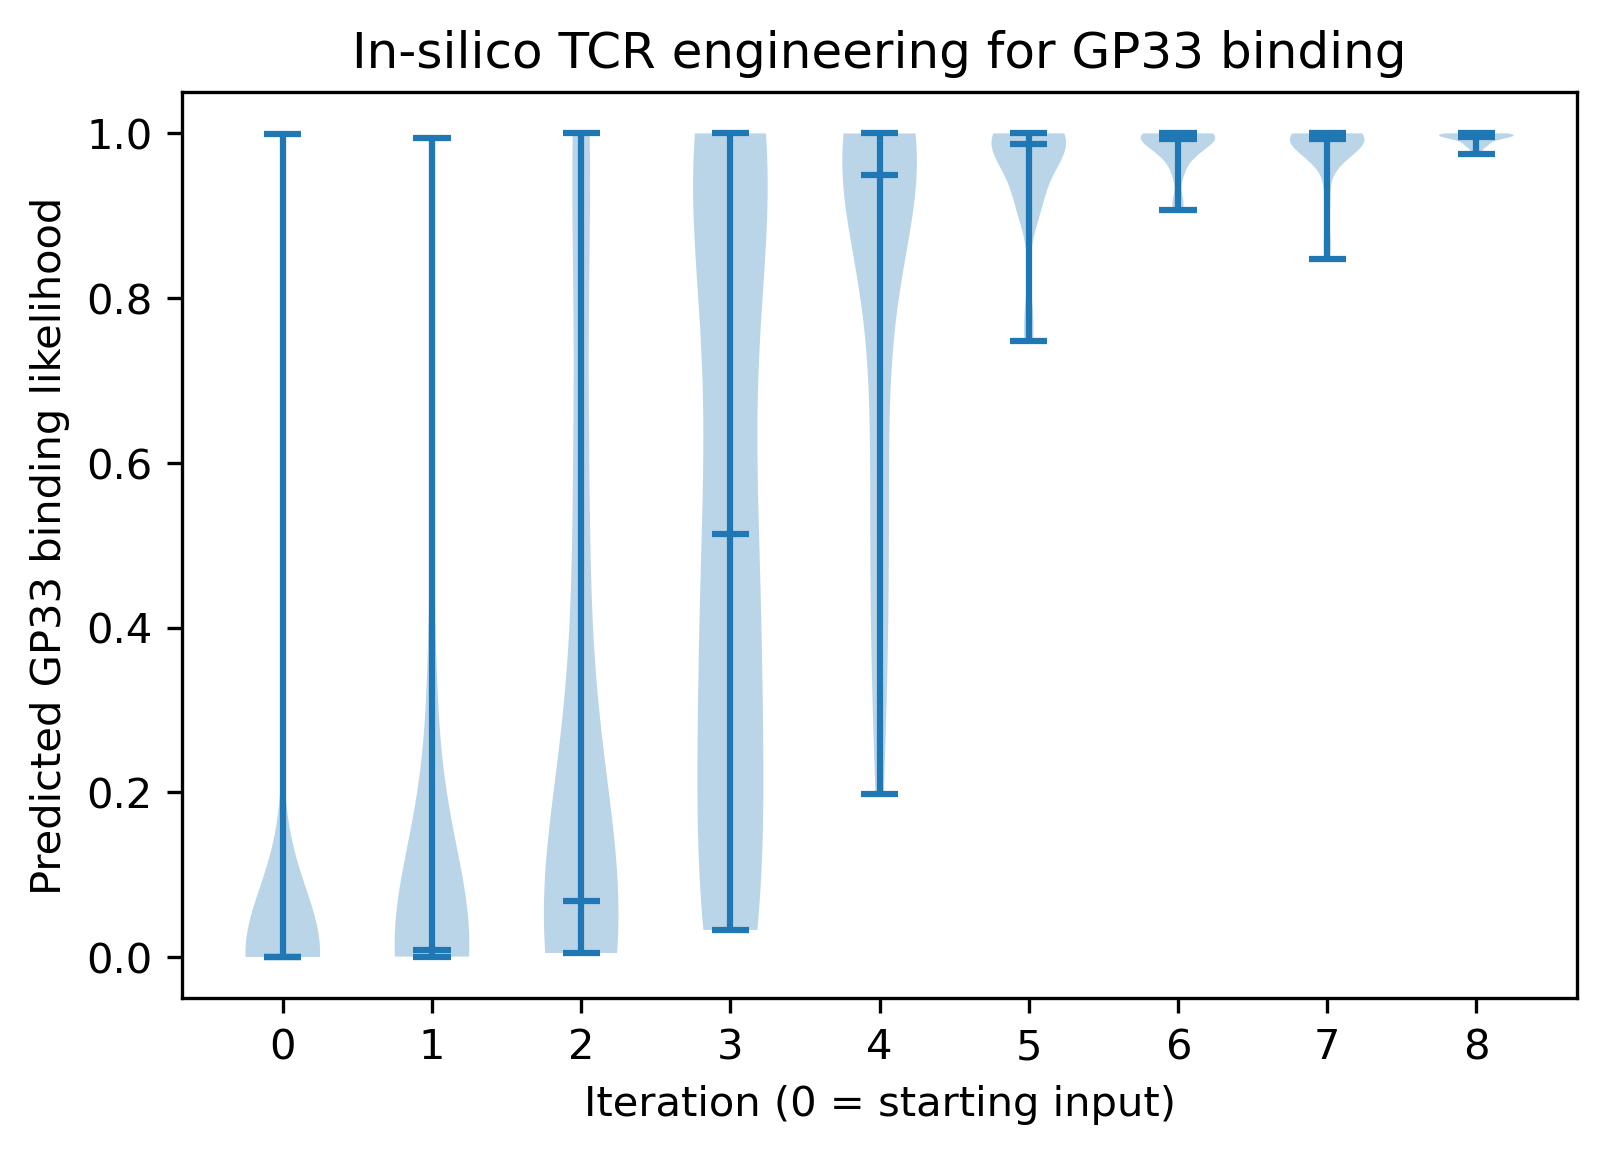

In [35]:
fig, ax = plt.subplots(dpi=300)
ax.violinplot(
    per_iteration_pvalues.T, positions=np.arange(len(per_iteration_pvalues)),
    showmedians=True, showextrema=True
)
ax.set(
    xlabel='Iteration (0 = starting input)',
    xticks=np.arange(len(per_iteration_pvalues)),
    ylabel='Predicted GP33 binding likelihood',
    title='In-silico TCR engineering for GP33 binding',
)
fig.savefig(plot_dir / 'pred_gp33_affinity_iters.pdf', bbox_inches='tight')
fig.show()

## Plot Similarity to Train Positives over Iterations

In [36]:
per_iteration_edit_distances = [[tra_trb_dist(p) for p in seq_set] for seq_set in per_iteration_best_seqs]

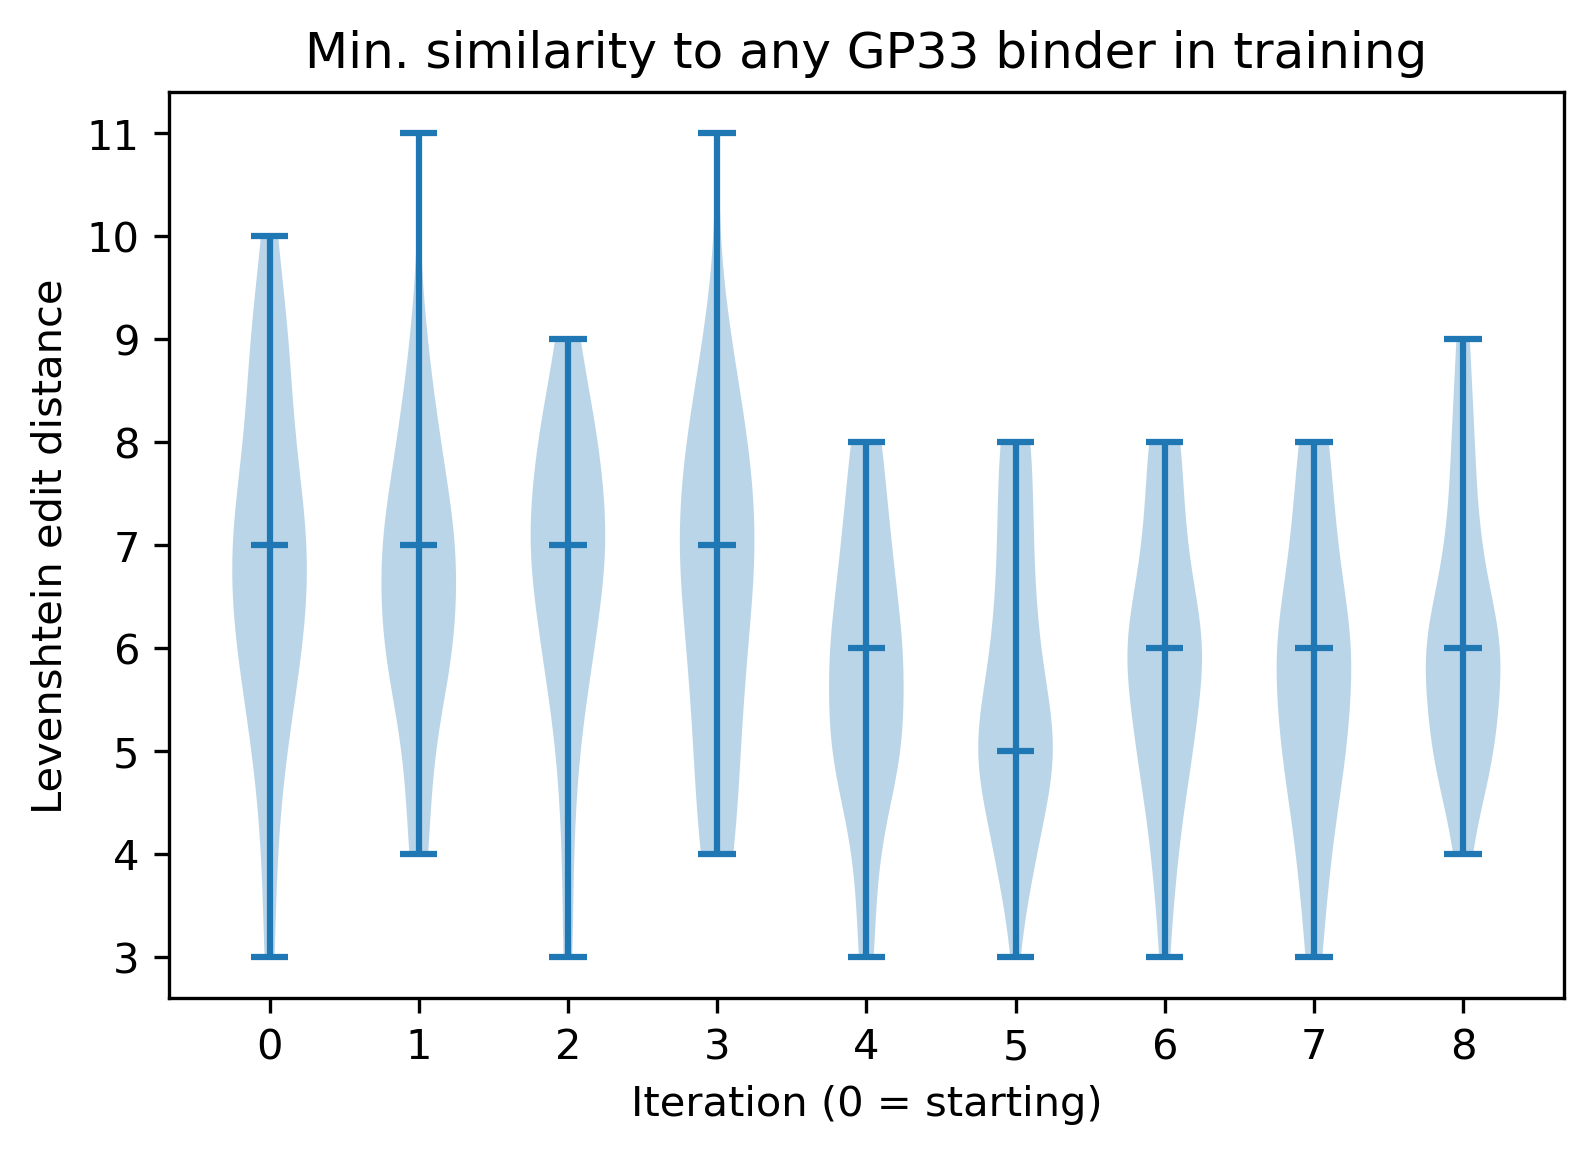

In [37]:
fig, ax = plt.subplots(dpi=300)
ax.violinplot(
    per_iteration_edit_distances, positions=np.arange(len(per_iteration_pvalues)),
    showmedians=True, showextrema=True,
)
ax.set(
    xlabel='Iteration (0 = starting)',
    xticks=np.arange(len(per_iteration_pvalues)),
    ylabel='Levenshtein edit distance',
    title='Min. similarity to any GP33 binder in training',
)
fig.savefig(plot_dir / 'similarity_known_binding_iters.pdf', bbox_inches='tight')
fig.show()

## UMAP to Compare Original and Generated Sequences

In [41]:
starting_df = pd.DataFrame({'TRA': starting_tras, 'TRB': starting_trbs, 'type': 'Starting'})
lcmv_train_neg_df = pd.DataFrame({'TRA': lcmv_train_neg['TRA'], 'TRB': lcmv_train_neg['TRB'], 'type': 'Train Negative'})
lcmv_train_pos_df = pd.DataFrame({'TRA': lcmv_train_pos['TRA'], 'TRB': lcmv_train_pos['TRB'], 'type': 'Train Positive'})
lcmv_test_neg_df = pd.DataFrame({'TRA': lcmv_test_neg['TRA'], 'TRB': lcmv_test_neg['TRB'], 'type': 'Test Negative'})
lcmv_test_pos_df = pd.DataFrame({'TRA': lcmv_test_pos['TRA'], 'TRB': lcmv_test_pos['TRB'], 'type': 'Test Positive'})
generated_df = pd.DataFrame({'TRA': generated_tras, 'TRB': generated_trbs, 'type': 'Generated'})

num_tcrs_per_set = 100

tcrs_df = pd.concat([
    df.sample(n=min(len(df), num_tcrs_per_set), replace=False, random_state=0)
    for df in [starting_df, lcmv_train_neg_df, lcmv_train_pos_df, lcmv_test_neg_df, lcmv_test_pos_df, generated_df]
])
tcrs_df

,TRA,TRB,type
26,CAMRGLSNYNVLYF,CASSLGQGAGNTLYF,Starting
86,CALRNSAGNKLTF,CASSLSGGAGENTLYF,Starting
2,CAAISSGSWQLIF,CASKLGGDQDTQYF,Starting
55,CAMREGASSGSWQLIF,CASSLDWGQDTQYF,Starting
75,CALSENYNQGKLIF,CASSSGTGGALYF,Starting
...,...,...,...
46,CATERGNNYAQGLTF,CASSLSMNTEVFF,Generated
3,CATDGGNNYAQGLTF,CASSFSANTEVFF,Generated
0,CAMSAPNYNQGKLIF,CASSLSGNTEVFF,Generated
47,CAVDRGGNYAQGLTF,CASSELARYEQYF,Generated


In [44]:
embeds = model_utils.get_transformer_embeddings(
    model_dir='wukevin/tcr-bert',
    seqs=tcrs_df['TRA'],
    seq_pair=tcrs_df['TRB'],
    device=device
)

Some weights of the model checkpoint at wukevin/tcr-bert were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [45]:
tcrs_adata = AnnData(embeds, obs=tcrs_df)
sc.pp.pca(tcrs_adata, n_comps=50)
sc.pp.neighbors(tcrs_adata, n_neighbors=20, knn=True, random_state=1234)
sc.tl.umap(tcrs_adata, min_dist=1.5, random_state=42)
tcrs_adata

/scratch/users/swansonk/miniconda3/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 550 × 768
    obs: 'TRA', 'TRB', 'type'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

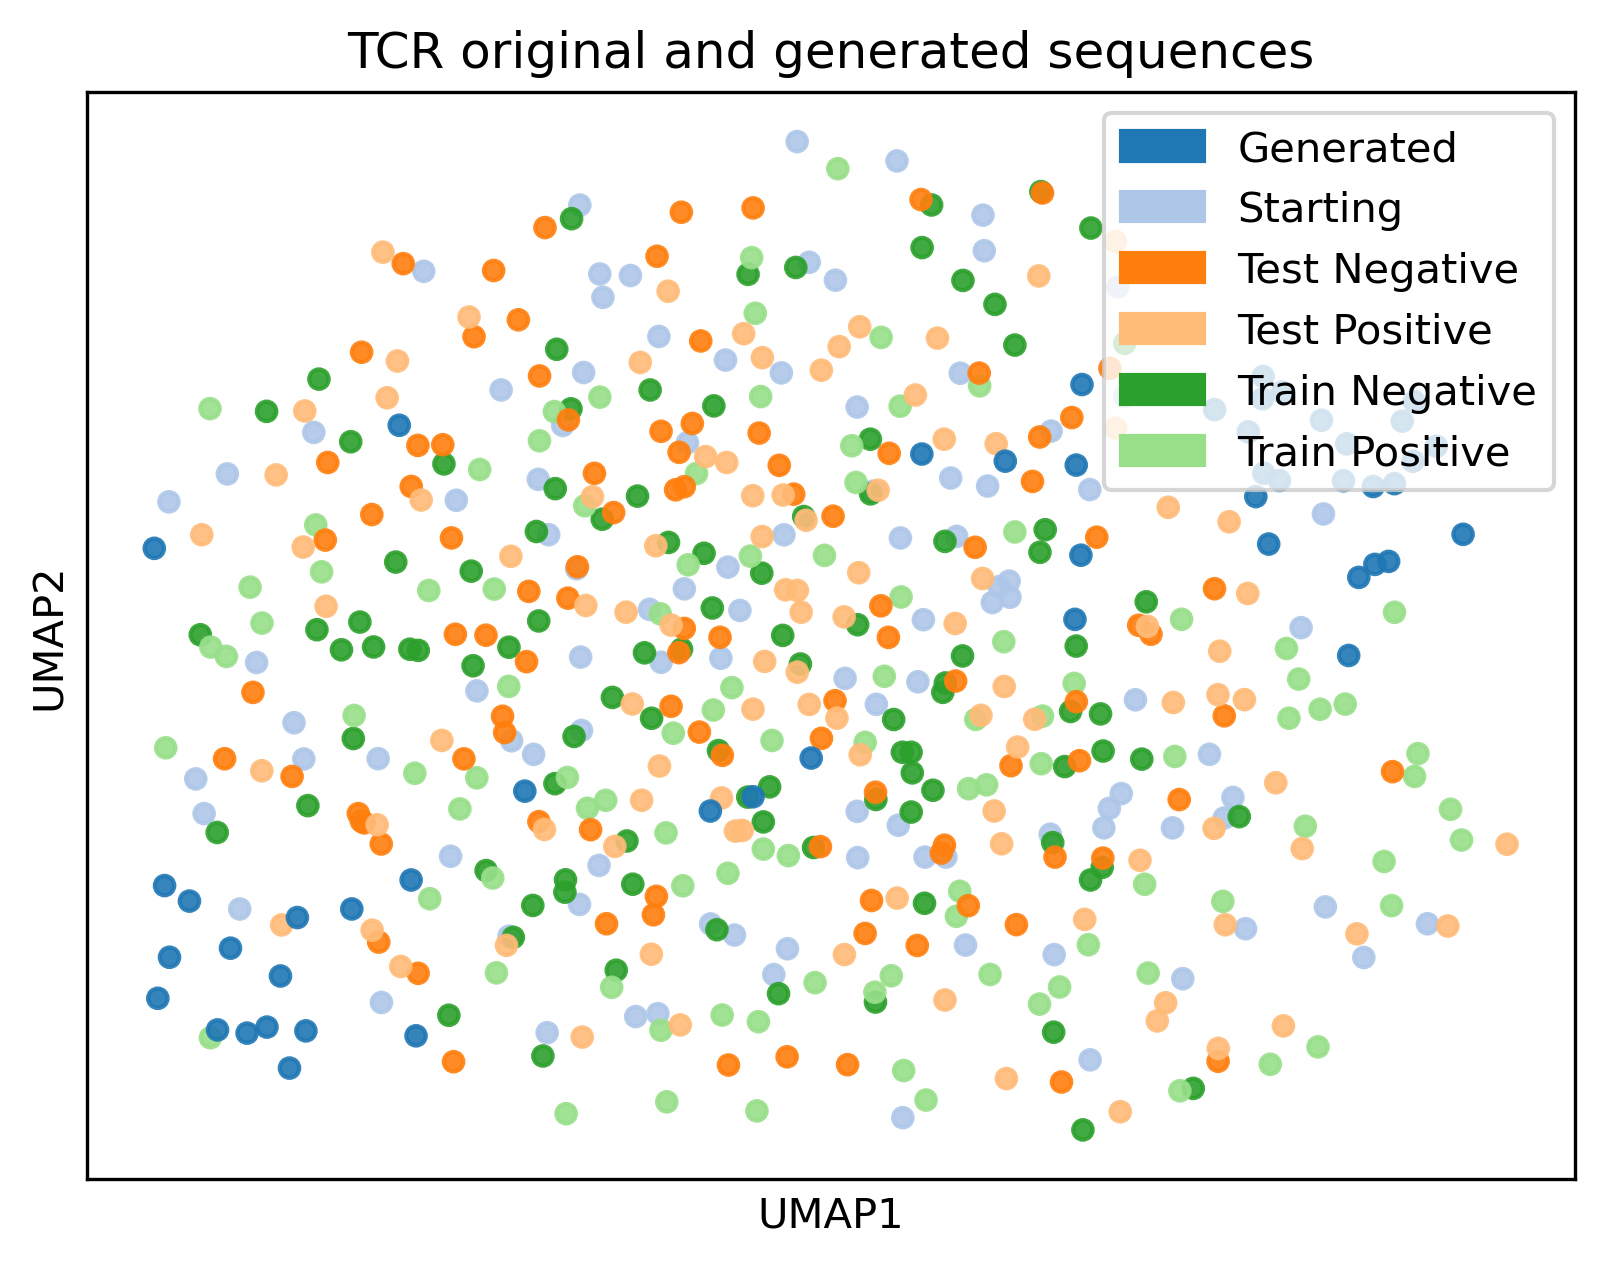

In [46]:
plot_utils.plot_anndata_rep(
    tcrs_adata,
    representation='umap',
    color='type',
    direct_label=False,
    alpha=0.8,
    title='TCR original and generated sequences',
    fname=plot_dir / 'tcr_original_vs_generated_umap.pdf'
).show()